# **1. DATA Cleaning**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn. preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn. utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore")

In [19]:
#Load Datasets
train=pd.read_csv("/content/drive/MyDrive/GUVI/Miniproject4/data/train_data.csv")
test=pd.read_csv("/content/drive/MyDrive/GUVI/Miniproject4/data/test_data.csv")
print("Train Shape:",train.shape)
print("Test Shape:",test.shape)

Train Shape: (132379, 14)
Test Shape: (33095, 14)


In [20]:
# Handling missing values
for col in train.select_dtypes(include=['float64','int64']).columns:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)

for col in train.select_dtypes(include=['object']).columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)


In [21]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


# **2.Feature Engineering**

In [22]:
print(train.columns.tolist())


['year', 'month', 'day', 'order', 'country', 'session_id', 'page1_main_category', 'page2_clothing_model', 'colour', 'location', 'model_photography', 'price', 'price_2', 'page']


In [23]:
# 1. Session length = max order number in session
train['session_length'] = train.groupby('session_id')['order'].transform('max')
test['session_length']  = test.groupby('session_id')['order'].transform('max')

# 2. Number of clicks per session
train['num_clicks'] = train.groupby('session_id')['order'].transform('count')
test['num_clicks']  = test.groupby('session_id')['order'].transform('count')

# 3. Time spent per product category (approx: count of clicks per category)
train['time_per_category'] = train.groupby(['session_id','page1_main_category'])['order'].transform('count')
test['time_per_category']  = test.groupby(['session_id','page1_main_category'])['order'].transform('count')


In [24]:
# Clickstream Patterns
# 4. First page visited in session
train['first_page'] = train.groupby('session_id')['page'].transform('first')
test['first_page']  = test.groupby('session_id')['page'].transform('first')

# 5. Last page visited in session
train['last_page'] = train.groupby('session_id')['page'].transform('last')
test['last_page']  = test.groupby('session_id')['page'].transform('last')
# 6. Number of unique categories viewed
train['unique_categories'] = train.groupby('session_id')['page1_main_category'].transform('nunique')
test['unique_categories']  = test.groupby('session_id')['page1_main_category'].transform('nunique')


In [25]:
# Behavioral Metrics
# 7. Bounce rate → session length = 1
train['is_bounce'] = train['session_length'].apply(lambda x: 1 if x == 1 else 0)
test['is_bounce']  = test['session_length'].apply(lambda x: 1 if x == 1 else 0)

# 8. Exit page → last page of the session
train['exit_page'] = train['last_page']
test['exit_page']  = test['last_page']

# 9. Revisit pattern → repeated visits to same product
train['is_revisit'] = train.groupby(['session_id','page2_clothing_model'])['page'].transform(lambda x: 1 if x.duplicated().any() else 0)
test['is_revisit']  = test.groupby(['session_id','page2_clothing_model'])['page'].transform(lambda x: 1 if x.duplicated().any() else 0)

print("Feature engineering completed!")
print(train.head())

Feature engineering completed!
   year  month  day  order  country  session_id  page1_main_category  \
0  2008      6   22     21       29       15648                    3   
1  2008      5   19      6       29       10018                    2   
2  2008      7   15      2       29       19388                    3   
3  2008      5    2      2       29        7181                    2   
4  2008      6    9     16       29       13493                    2   

  page2_clothing_model  colour  location  ...  page  session_length  \
0                  C20      13         1  ...     2             107   
1                  B26      13         3  ...     2              13   
2                  C13       9         5  ...     1              11   
3                  B11       2         4  ...     1               8   
4                  B31       9         5  ...     2              17   

   num_clicks  time_per_category  first_page  last_page  unique_categories  \
0          84                 3

In [26]:
# Copy dataset for EDA
eda_df = train.copy()

In [27]:
# Check categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# If categorical columns exist, encode them
if len(categorical_cols) > 0:
    from sklearn.preprocessing import LabelEncoder
    for col in categorical_cols:
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        if col in test.columns:
            mapping = {cls: idx for idx, cls in enumerate(le.classes_)}
            test[col] = test[col].map(mapping)

            test[col].fillna(-1, inplace=True)
            test[col] = test[col].astype(int)


Categorical columns: ['page2_clothing_model']


In [28]:
# Scaling all numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target columns from numerical columns
numerical_cols = [col for col in numerical_cols if col not in ['PRICE', 'PRICE_2']]

scaler = StandardScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

# **3. Exploratory Data Analysis (EDA)**

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132379 entries, 0 to 132378
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  132379 non-null  float64
 1   month                 132379 non-null  float64
 2   day                   132379 non-null  float64
 3   order                 132379 non-null  float64
 4   country               132379 non-null  float64
 5   session_id            132379 non-null  float64
 6   page1_main_category   132379 non-null  float64
 7   page2_clothing_model  132379 non-null  float64
 8   colour                132379 non-null  float64
 9   location              132379 non-null  float64
 10  model_photography     132379 non-null  float64
 11  price                 132379 non-null  float64
 12  price_2               132379 non-null  float64
 13  page                  132379 non-null  float64
 14  session_length        132379 non-null  float64
 15  

In [30]:
# Map categorical variables

country_map = {
    "1": "Australia", "2": "Austria", "3": "Belgium", "4": "British Virgin Islands",
    "5": "Cayman Islands", "6": "Christmas Island", '7': "Croatia", '8': "Cyprus",
    '9': "Czech Republic", '10': "Denmark", "11": "Estonia", "12": "unidentified",
    "13": "Faroe Islands", "14": "Finland", "15": "France", "16": "Germany",
    '17': "Greece", "18": "Hungary", "19": "Iceland", "20": "India", "21": "Ireland",
    "22": "Italy", "23": "Latvia", "24": "Lithuania", "25": "Luxembourg", "26": "Mexico",
    "27": "Netherlands", "28": "Norway", "29": "Poland", "30": "Portugal", "31": "Romania",
    '32': "Russia", '33': "San Marino", "34": "Slovakia", "35": "Slovenia", "36": "Spain",
    '37': "Sweden", "38": "Switzerland", "39": "Ukraine", "40": "United Arab Emirates",
    "41": "United Kingdom", "42": "USA", "43": "biz (.biz)", "44": "com (.com)",
    "45": "int (.int)", "46": "net (.net)", "47": "org (*.org)"
}

page1_map = {1: "trousers", 2: "skirts", 3: "blouses", 4: "sale"}
colour_map = {1:"beige",2:"black",3:"blue",4:"brown",5:"burgundy",6:"gray",7:"green",
              8:"navy blue",9:"of many colors",10:"olive",11:"pink",12:"red",13:"violet",14:"white"}
location_map = {1:"top left",2:"top middle",3:"top right",4:"bottom left",
                5:"bottom middle",6:"bottom right"}
model_photo_map = {1:"en face",2:"profile"}

# Map and convert to categorical, handle unmapped values
eda_df['page1_main_category'] = pd.Categorical(eda_df['page1_main_category'])
eda_df['colour'] = pd.Categorical(eda_df['colour'])
eda_df['location'] = pd.Categorical(eda_df['location'])
eda_df['model_photography'] = pd.Categorical(eda_df['model_photography'])
eda_df['country'] = pd.Categorical(eda_df['country'])


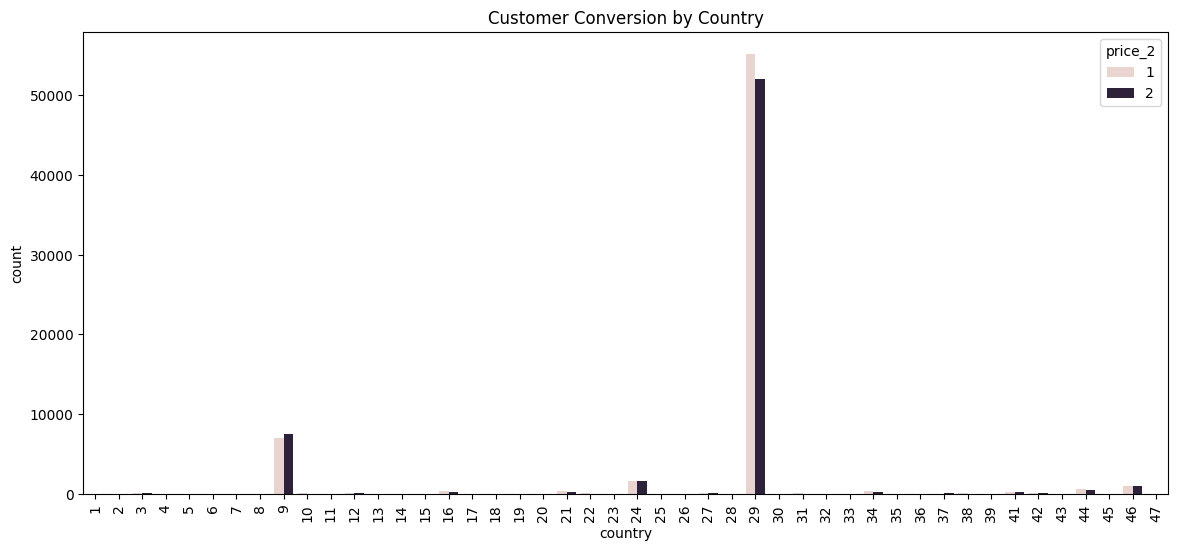

In [31]:
# 1. Visualizations
plt.figure(figsize=(14,6))
sns.countplot(data=eda_df, x='country', hue='price_2', order=eda_df['country'].cat.categories)
plt.xticks(rotation=90)
plt.title("Customer Conversion by Country")
plt.show()



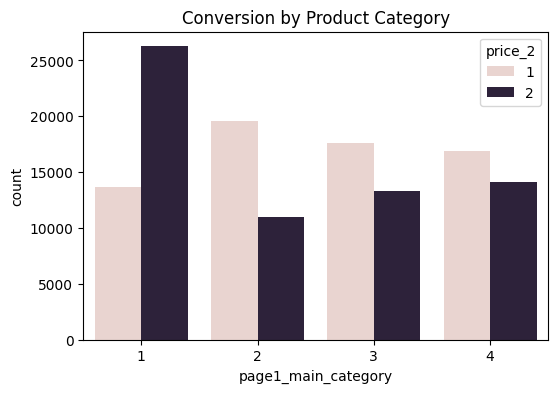

In [32]:
# Conversion by Main Category
plt.figure(figsize=(6,4))
sns.countplot(
    data=eda_df,
    x='page1_main_category',
    hue='price_2',
    order=eda_df['page1_main_category'].cat.categories
)
plt.title("Conversion by Product Category")
plt.show()


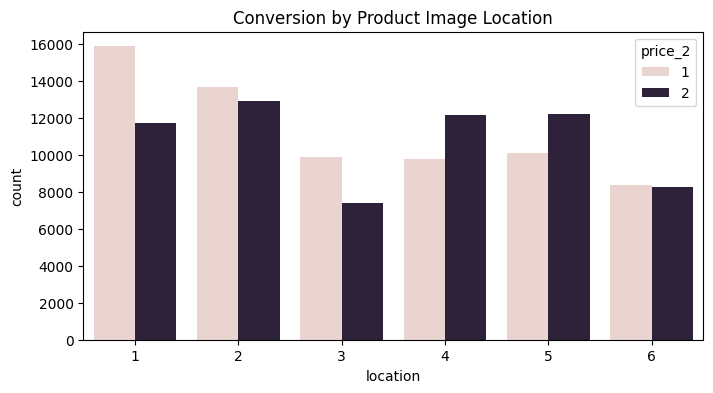

In [33]:
# Conversion by Location
plt.figure(figsize=(8,4))
sns.countplot(data=eda_df, x='location', hue='price_2', order=eda_df['location'].cat.categories)
plt.title("Conversion by Product Image Location")
plt.show()


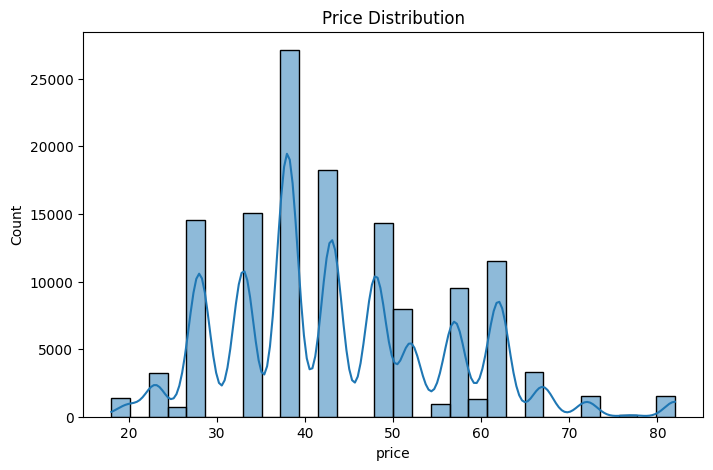

In [34]:
# Histogram: PRICE distribution
plt.figure(figsize=(8,5))
sns.histplot(eda_df['price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.show()

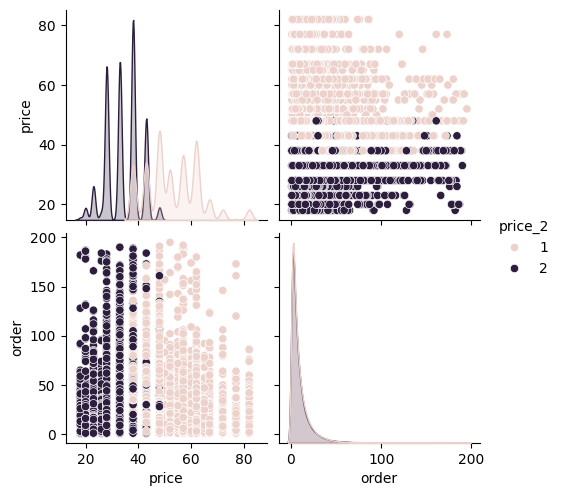

In [35]:
# Pair plot for numerical features
num_cols = ['price','order']
sns.pairplot(eda_df[num_cols + ['price_2']], hue='price_2')
plt.show()


In [36]:
# 2. Session Analysis

eda_df['session_length'] = eda_df.groupby('session_id')['order'].transform('max')
eda_df['num_clicks'] = eda_df.groupby('session_id')['order'].transform('count')
eda_df['is_bounce'] = np.where(eda_df['order']==1, 1, 0)

session_summary = eda_df.groupby('session_id').agg({
    'session_length':'max',
    'num_clicks':'count',
    'is_bounce':'mean'
}).reset_index()
print("Session Summary:")
print(session_summary.describe())


Session Summary:
         session_id  session_length    num_clicks     is_bounce
count  22910.000000    22910.000000  22910.000000  22910.000000
mean   12029.363684        6.982366      5.778219      0.362360
std     6941.966183        9.094983      7.324557      0.357997
min        1.000000        1.000000      1.000000      0.000000
25%     6011.500000        2.000000      2.000000      0.083333
50%    12043.500000        4.000000      3.000000      0.250000
75%    18048.500000        9.000000      7.000000      0.500000
max    24026.000000      195.000000    164.000000      1.000000


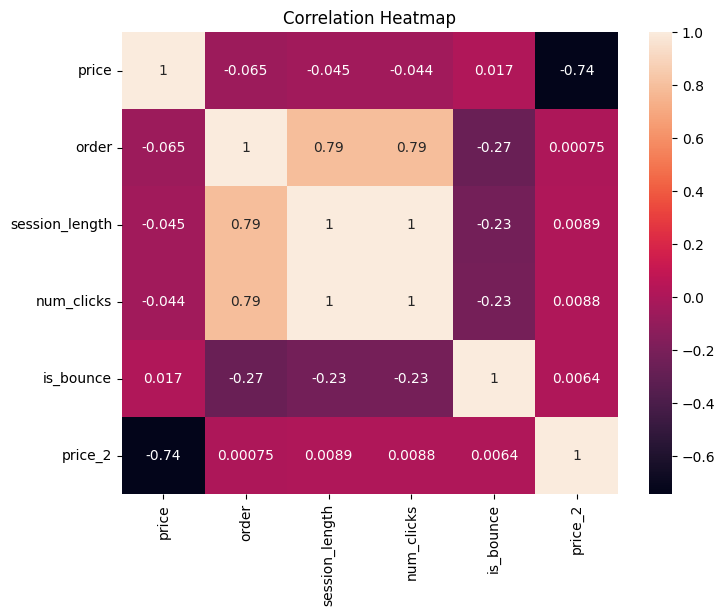

In [37]:
# 3. Correlation Analysis

plt.figure(figsize=(8,6))
sns.heatmap(eda_df[['price','order','session_length','num_clicks','is_bounce','price_2']].corr(),
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

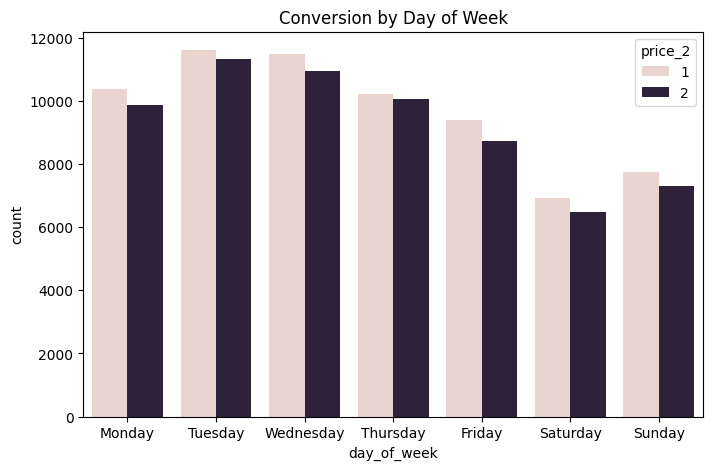

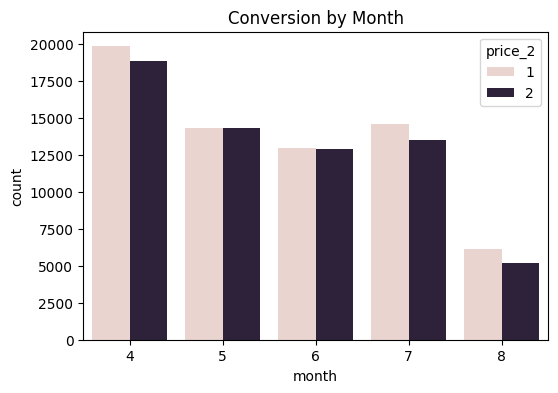

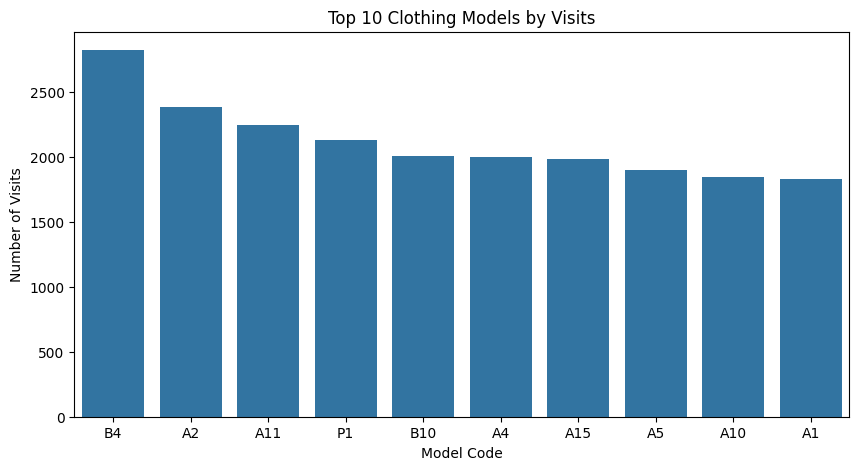

In [38]:
# 4. Time-based Analysis
# Ensure numeric
eda_df['year'] = pd.to_numeric(eda_df['year'], errors='coerce')
eda_df['month'] = pd.to_numeric(eda_df['month'], errors='coerce')
eda_df['day'] = pd.to_numeric(eda_df['day'], errors='coerce')

# Create datetime safely
eda_df['date'] = pd.to_datetime(
    eda_df[['year', 'month', 'day']],
    errors='coerce'  # invalid dates become NaT
)

# Extract hour and day of week safely
eda_df['hour'] = eda_df['date'].dt.hour.fillna(0).astype(int)  # fill missing with 0
eda_df['day_of_week'] = eda_df['date'].dt.day_name().fillna('Unknown')

# Conversion by day of week
plt.figure(figsize=(8,5))
sns.countplot(
    data=eda_df,
    x='day_of_week',
    hue='price_2',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.title("Conversion by Day of Week")
plt.show()

# Conversion by month
plt.figure(figsize=(6,4))
sns.countplot(data=eda_df, x='month', hue='price_2')
plt.title("Conversion by Month")
plt.show()



# 5. PAGE 2 (Clothing Model) Analysis

# Top 10 clothing models by visits
top_models = eda_df['page2_clothing_model'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_models.index, y=top_models.values)
plt.title("Top 10 Clothing Models by Visits")
plt.xlabel("Model Code")
plt.ylabel("Number of Visits")
plt.show()


# **4. Balancing Techniques (For Classification Models)**


Target distribution before balancing:
Counter({-0.9772268845307731: 67714, 1.0233038159609795: 64665})


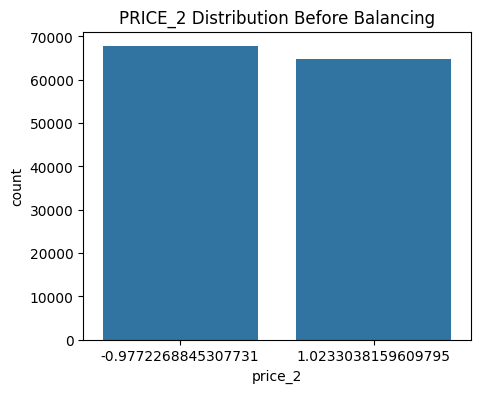

In [39]:
## Identify Imbalance
print("Target distribution before balancing:")
print(Counter(train['price_2']))

plt.figure(figsize=(5,4))
sns.countplot(x=train['price_2'])
plt.title("PRICE_2 Distribution Before Balancing")
plt.show()

In [40]:
# Define Feature Sets for Different Tasks
# Non-feature columns
non_feature_cols = ['session_id', 'price', 'price_2']

# Features for classification
X_class = train.drop(columns=non_feature_cols, errors='ignore')
# Ensure price_2 is integer for classification
y_class = train['price_2'].astype(int)

# Features for regression
X_reg = train.drop(columns=['session_id', 'price'], errors='ignore')
y_reg = train['price']

# Features for clustering (unsupervised)
X_clu = train.drop(columns=['session_id', 'price', 'price_2'], errors='ignore')


Target distribution after SMOTE:
Counter({0: 67714, 1: 67714})


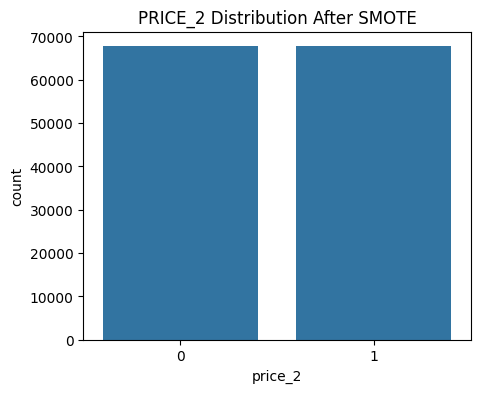

In [41]:
#  Oversampling for Classification (SMOTE)
smote = SMOTE(random_state=42)
X_class_res, y_class_res = smote.fit_resample(X_class, y_class)

print("Target distribution after SMOTE:")
print(Counter(y_class_res))

plt.figure(figsize=(5,4))
sns.countplot(x=y_class_res)
plt.title("PRICE_2 Distribution After SMOTE")
plt.show()

# **5. Model Building**

In [ ]:
#classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split data
Xc_train, Xc_val, yc_train, yc_val = train_test_split(X_class_res, y_class_res, test_size=0.2, random_state=42)

# Define models and parameters
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'NeuralNetwork': MLPClassifier(max_iter=500, random_state=42)
}

# Optional: Hyperparameters for GridSearchCV (example for RF and DT)
params = {
    'DecisionTree': {'model__max_depth':[5,10,None],'model__min_samples_split':[2,5]},
    'RandomForest': {'model__n_estimators':[100,200],'model__max_depth':[5,10,None]},
    'XGBoost': {'model__n_estimators':[100,200],'model__max_depth':[3,5],'model__learning_rate':[0.01,0.1]},
    'NeuralNetwork': {'model__hidden_layer_sizes':[(50,50),(100,)], 'model__activation':['relu','tanh']}
}

results = {}

# Loop over models
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Use GridSearch if hyperparameters defined
    if name in params:
        grid = GridSearchCV(pipeline, params[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(Xc_train, yc_train)
        best_model = grid.best_estimator_
        print(f"Best params for {name}: {grid.best_params_}")
    else:
        pipeline.fit(Xc_train, yc_train)
        best_model = pipeline

    # Predictions
    y_pred = best_model.predict(Xc_val)

    # Metrics
    acc = accuracy_score(yc_val, y_pred)
    prec = precision_score(yc_val, y_pred, average='weighted', zero_division=0)
    rec = recall_score(yc_val, y_pred, average='weighted')
    f1 = f1_score(yc_val, y_pred, average='weighted')

    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Display results
results_df = pd.DataFrame(results).T
print("\nClassification Results:\n", results_df)



Training LogisticRegression...

Training DecisionTree...
Best params for DecisionTree: {'model__max_depth': None, 'model__min_samples_split': 2}

Training RandomForest...
Best params for RandomForest: {'model__max_depth': None, 'model__n_estimators': 200}

Training XGBoost...
Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}

Training NeuralNetwork...


In [17]:
import pickle

# Save the best RandomForest model (pipeline)
with open("best_classifier.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("RandomForest classifier saved as 'best_classifier.pkl'")


NameError: name 'best_model' is not defined

In [29]:
#Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Regression Features & Target
X_reg = train.drop(columns=['session_id','price'], errors='ignore')
y_reg = train['price']

from sklearn.model_selection import train_test_split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Define Models
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train & Evaluate Models
regression_results = {}

for name, model in regressors.items():
    model.fit(X_reg_train, y_reg_train)
    y_pred = model.predict(X_reg_test)

    mae = mean_absolute_error(y_reg_test, y_pred)
    mse = mean_squared_error(y_reg_test, y_pred)
    rmse = np.sqrt(mse)   # Manually compute RMSE
    r2 = r2_score(y_reg_test, y_pred)

    regression_results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

import pandas as pd
pd.DataFrame(regression_results).T


,MAE,MSE,RMSE,R2
LinearRegression,0.347881,0.212221,0.460675,0.789482
Ridge,0.347878,0.212221,0.460675,0.789482
Lasso,0.350555,0.216073,0.464837,0.785661
GradientBoosting,0.137069,0.045892,0.214224,0.954476


In [15]:
#Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

# Features for clustering
X_clu = train.drop(columns=['session_id','price','price_2'], errors='ignore')




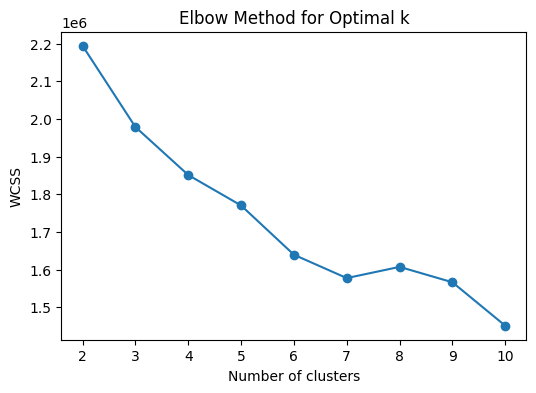

K-Means Silhouette Score: 0.10244063411500076
K-Means Davies-Bouldin Index: 2.071677855633642
K-Means WCSS: 1577684.2012139787


In [17]:
# 1. K-Means Clustering

# Determine optimal number of clusters using Elbow Method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clu)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# Fit K-Means with chosen k
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_labels = kmeans.fit_predict(X_clu)

print("K-Means Silhouette Score:", silhouette_score(X_clu, kmeans_labels))
print("K-Means Davies-Bouldin Index:", davies_bouldin_score(X_clu, kmeans_labels))
print("K-Means WCSS:", kmeans.inertia_)




In [18]:
# 2. DBSCAN Clustering

dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_clu)

# Filter out noise points for silhouette
mask = dbscan_labels != -1
if np.sum(mask) > 1:  # At least 2 clusters for silhouette
    print("DBSCAN Silhouette Score:", silhouette_score(X_clu[mask], dbscan_labels[mask]))
    print("DBSCAN Davies-Bouldin Index:", davies_bouldin_score(X_clu[mask], dbscan_labels[mask]))
else:
    print("DBSCAN: Not enough clusters for silhouette score")





DBSCAN Silhouette Score: -0.13117790140122418
DBSCAN Davies-Bouldin Index: 1.0837584804936693


In [16]:
# 3. Hierarchical Clustering (Agglomerative)

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Sample data to reduce memory usage
sample_size = 10000
X_clu_sample = X_clu.sample(n=sample_size, random_state=42)
# Optional: Reduce dimensionality

pca = PCA(n_components=10, random_state=42)
X_clu_reduced = pca.fit_transform(X_clu_sample)
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=7)
agglo_labels = agglo.fit_predict(X_clu_reduced)
# Cluster Evaluation
sil_score = silhouette_score(X_clu_reduced, agglo_labels)
db_score = davies_bouldin_score(X_clu_reduced, agglo_labels)

print("Agglomerative Silhouette Score:", sil_score)
print("Agglomerative Davies-Bouldin Index:", db_score)


Agglomerative Silhouette Score: 0.1014014863415399
Agglomerative Davies-Bouldin Index: 2.0194496552384815
